##### s3 configuration

In [1]:
import boto3
import io
import s3fs
import torch

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import torch.nn as nn

from collections import OrderedDict
from torchvision import models, transforms


In [2]:
s3 = boto3.resource("s3",
                    endpoint_url = "http://192.168.0.29",
                    aws_access_key_id="AKIAPo19vPR_TJaeVgleCiOSUw",
                    aws_secret_access_key="7cSWM1KCXvRpK4ICeDEAfuicEm+QQeuhqOi7cejZ",
                    region_name = 'eu-central-1',
               )
s3_client = boto3.client("s3",
                    endpoint_url = "http://192.168.0.29",
                    aws_access_key_id="AKIAPo19vPR_TJaeVgleCiOSUw",
                    aws_secret_access_key="7cSWM1KCXvRpK4ICeDEAfuicEm+QQeuhqOi7cejZ",
                   )
               

In [3]:
## load pretrained model
def load_checkpoint(file_path):
    state_dict = torch.load(file_path, map_location="cpu")
    
    model = models.densenet201(pretrained=True)
    model.class_to_idx = state_dict["class_to_idx"]
    
    classifier = classifier = nn.Sequential(OrderedDict([
              ('fc1', nn.Linear(1920, 500)),
              ('relu1', nn.ReLU()),
              ('dropout1', nn.Dropout(p=0.2)),
              ('fc2', nn.Linear(500, 256)),
              ('relu2', nn.ReLU()),
              ('dropout2', nn.Dropout(p=0.2)),
              ('fc3', nn.Linear(256, 5)),
              ('output', nn.LogSoftmax(dim=1))
              
        ]))
    model.classifier = classifier
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.load_state_dict(state_dict["state_dict"], strict=False)
    
    return model

In [4]:
kwargs = {'endpoint_url':"http://192.168.0.29",
          }
client = s3fs.S3FileSystem(key="AKIAPo19vPR_TJaeVgleCiOSUw", 
                                secret="7cSWM1KCXvRpK4ICeDEAfuicEm+QQeuhqOi7cejZ",
                                use_ssl=False,
                            
                                client_kwargs=kwargs)

In [5]:
file_obj = s3_client.get_object(Bucket = "saved-models", Key = "classifier.pth") 

In [6]:
file_obj

{'ResponseMetadata': {'RequestId': '20921bbe-70bd-447a-96a2-7602060f3122',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'last-modified': 'Mon, 26 Apr 2021 23:03:29 GMT',
   'content-type': '',
   'etag': '"e92f8e698c3a7362714c926b6470b53e"',
   'accept-ranges': 'bytes',
   'content-length': '78110909',
   'x-amz-request-id': '20921bbe-70bd-447a-96a2-7602060f3122',
   'server': 'SeagateS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 4, 26, 23, 3, 29, tzinfo=tzutc()),
 'ContentLength': 78110909,
 'ETag': '"e92f8e698c3a7362714c926b6470b53e"',
 'ContentType': '',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x13593ca90>}

In [7]:
# load the model
model_saved = io.BytesIO(file_obj['Body'].read())
model = load_checkpoint(model_saved)

In [8]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
def process_image(image_path):
    
    test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    from PIL import Image
    im = Image.open(image_path)
    im = test_transform(im)

    return im

In [10]:
def predict(image, model):
    # we have to process the image as we did while training the others
    image = process_image(image)
    
    image_input = image.unsqueeze(0)
    
    model.eval()
    outputs = model(image_input)
    ps = torch.exp(outputs)
    
    top_p, top_cls = ps.topk(5, dim=1)
    top_cls = top_cls.detach().numpy().tolist()[0]
    
    # covert indices to classes
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    
    top_cls = [idx_to_class[top_class] for top_class in top_cls]
    
    return top_p, top_cls

In [11]:
def imshow(image, ax=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        # if the data loader has transform.normalize
        # undo preprocessing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

In [12]:
def plot_solution(image_path, ps, classes):
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    image = process_image(image_path)
    imshow(image, ax)

    plt.subplot(2,1,2)
    sns.barplot(x=ps, y=classes, color=sns.color_palette()[2]);
    plt.show()

##### Inference
- You can know infer(check how the model perfoms on test data)
- This image is saved on the local storage, although you can also decide to store the test images on the Cotrx-s3 and read them as we read the training and validation images

[0.9860456585884094, 0.01021088007837534, 0.0021262899972498417, 0.001383343362249434, 0.00023385454551316798]
['Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Apple___Apple_scab', 'Background_without_leaves']


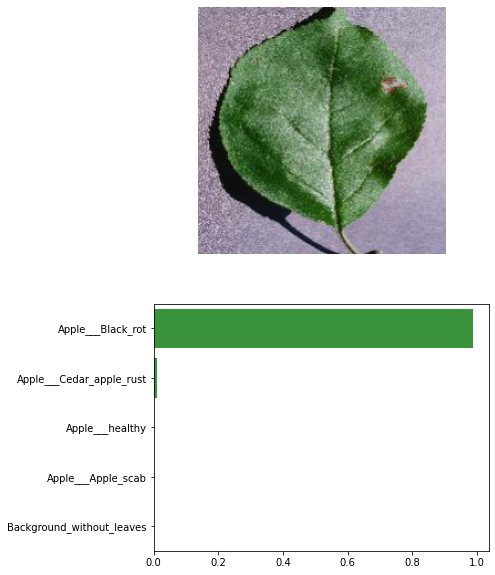

In [13]:
image = "data/test_images/image (106).JPG"
ps, classes = predict(image, model)
ps = ps.detach().numpy().tolist()[0]
print(ps)
print(classes)

plot_solution(image, ps, classes)
